In [3]:
import tensorflow as tf
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle
import cv2
import pandas as pd
from tqdm import tqdm
import datetime as dt

In [4]:
from tensorflow.python.client import device_lib
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print(device_lib.list_local_devices())

Num GPUs Available:  1
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 4725182327386491821
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 4930941747
locality {
  bus_id: 1
  links {
  }
}
incarnation: 10752438453201058460
physical_device_desc: "device: 0, name: GeForce GTX 1060, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


In [5]:
with open('Models/model1.json', 'r') as j_file:
    loaded_model_json = j_file.read()
model1 = tf.keras.models.model_from_json(loaded_model_json)
model1.load_weights("Models/model1.h5")

In [6]:
model1.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_4 (Batch (None, 32, 32, 3)         12        
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 30, 30, 32)        896       
_________________________________________________________________
gaussian_noise_9 (GaussianNo (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 28, 28, 32)        9248      
_________________________________________________________________
dropout_15 (Dropout)         (None, 28, 28, 32)        0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 26, 26, 64)        18496     
_________________________________________________________________
gaussian_noise_10 (GaussianN (None, 26, 26, 64)       

In [118]:
def loadPreprocess():
    ### Load In Data
    (trainX, trainY), (testX, testY) = tf.keras.datasets.cifar10.load_data()
    trainY = tf.keras.utils.to_categorical(trainY)
    testY = tf.keras.utils.to_categorical(testY)
    return [trainX/255, trainY, testX/255, testY]

def returnClassIndex(trainY,class_index):
    labels = np.argmax(trainY, axis = 1)
    return [ i for i in range(len(labels)) if labels[i] == class_index]

trainX, trainY, testX, testY = loadPreprocess()
model2  = tf.keras.Model(inputs = model1.input,
                         outputs = model1.get_layer(model1.layers[-3].name).output
                        )
model1.compile(optimizer = tf.keras.optimizers.Adam(), 
               loss = "categorical_crossentropy",  metrics= ['accuracy']
              )
### Predictions
p = model1.predict(trainX,  verbose = 1)
preds = np.argmax(p, axis= 1)
c, f = np.unique(preds, return_counts = True)

<BarContainer object of 10 artists>

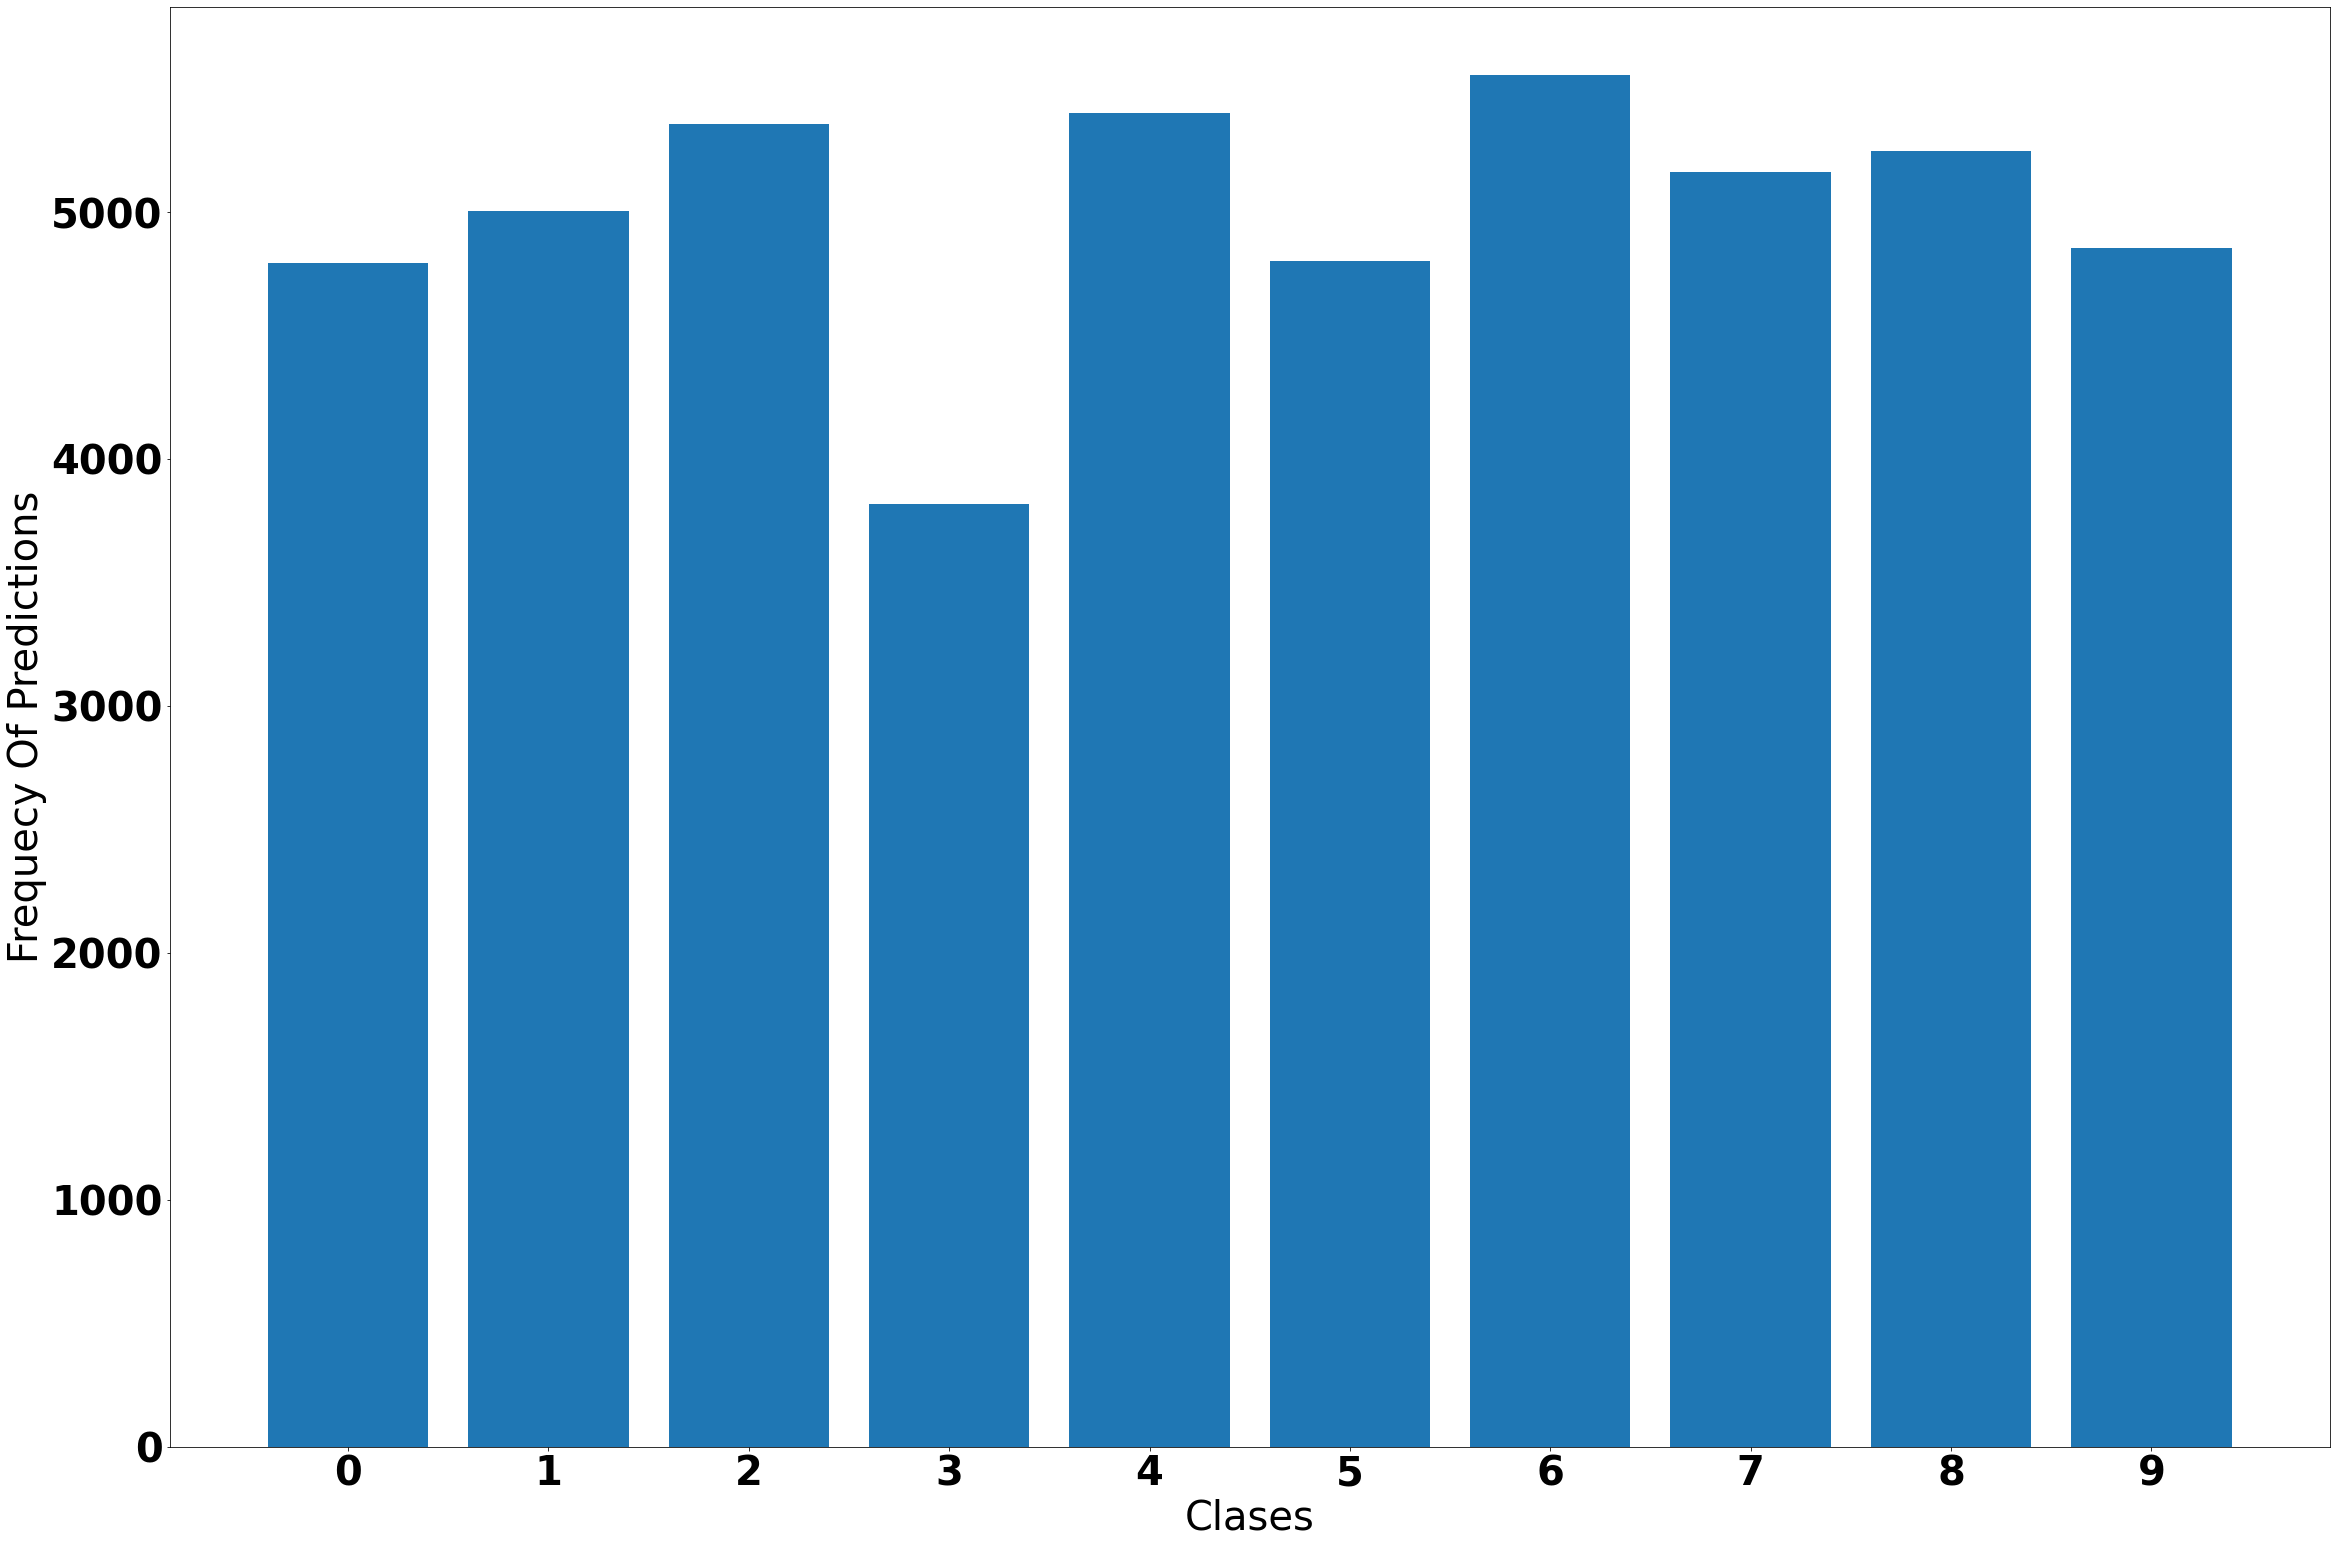

In [72]:
%matplotlib inline
fig = plt.figure( figsize = (30,20))
font = {'family' : 'sans',
        'weight' : 'bold',
        'size'   : 40}

matplotlib.rc('font', **font)
ax = fig.add_axes([0,0,1,1 ])
ax.set_xlabel("Clases")
ax.set_ylabel("Frequecy Of Predictions")
ax.set_xticks(c)
ax.bar(c,f)

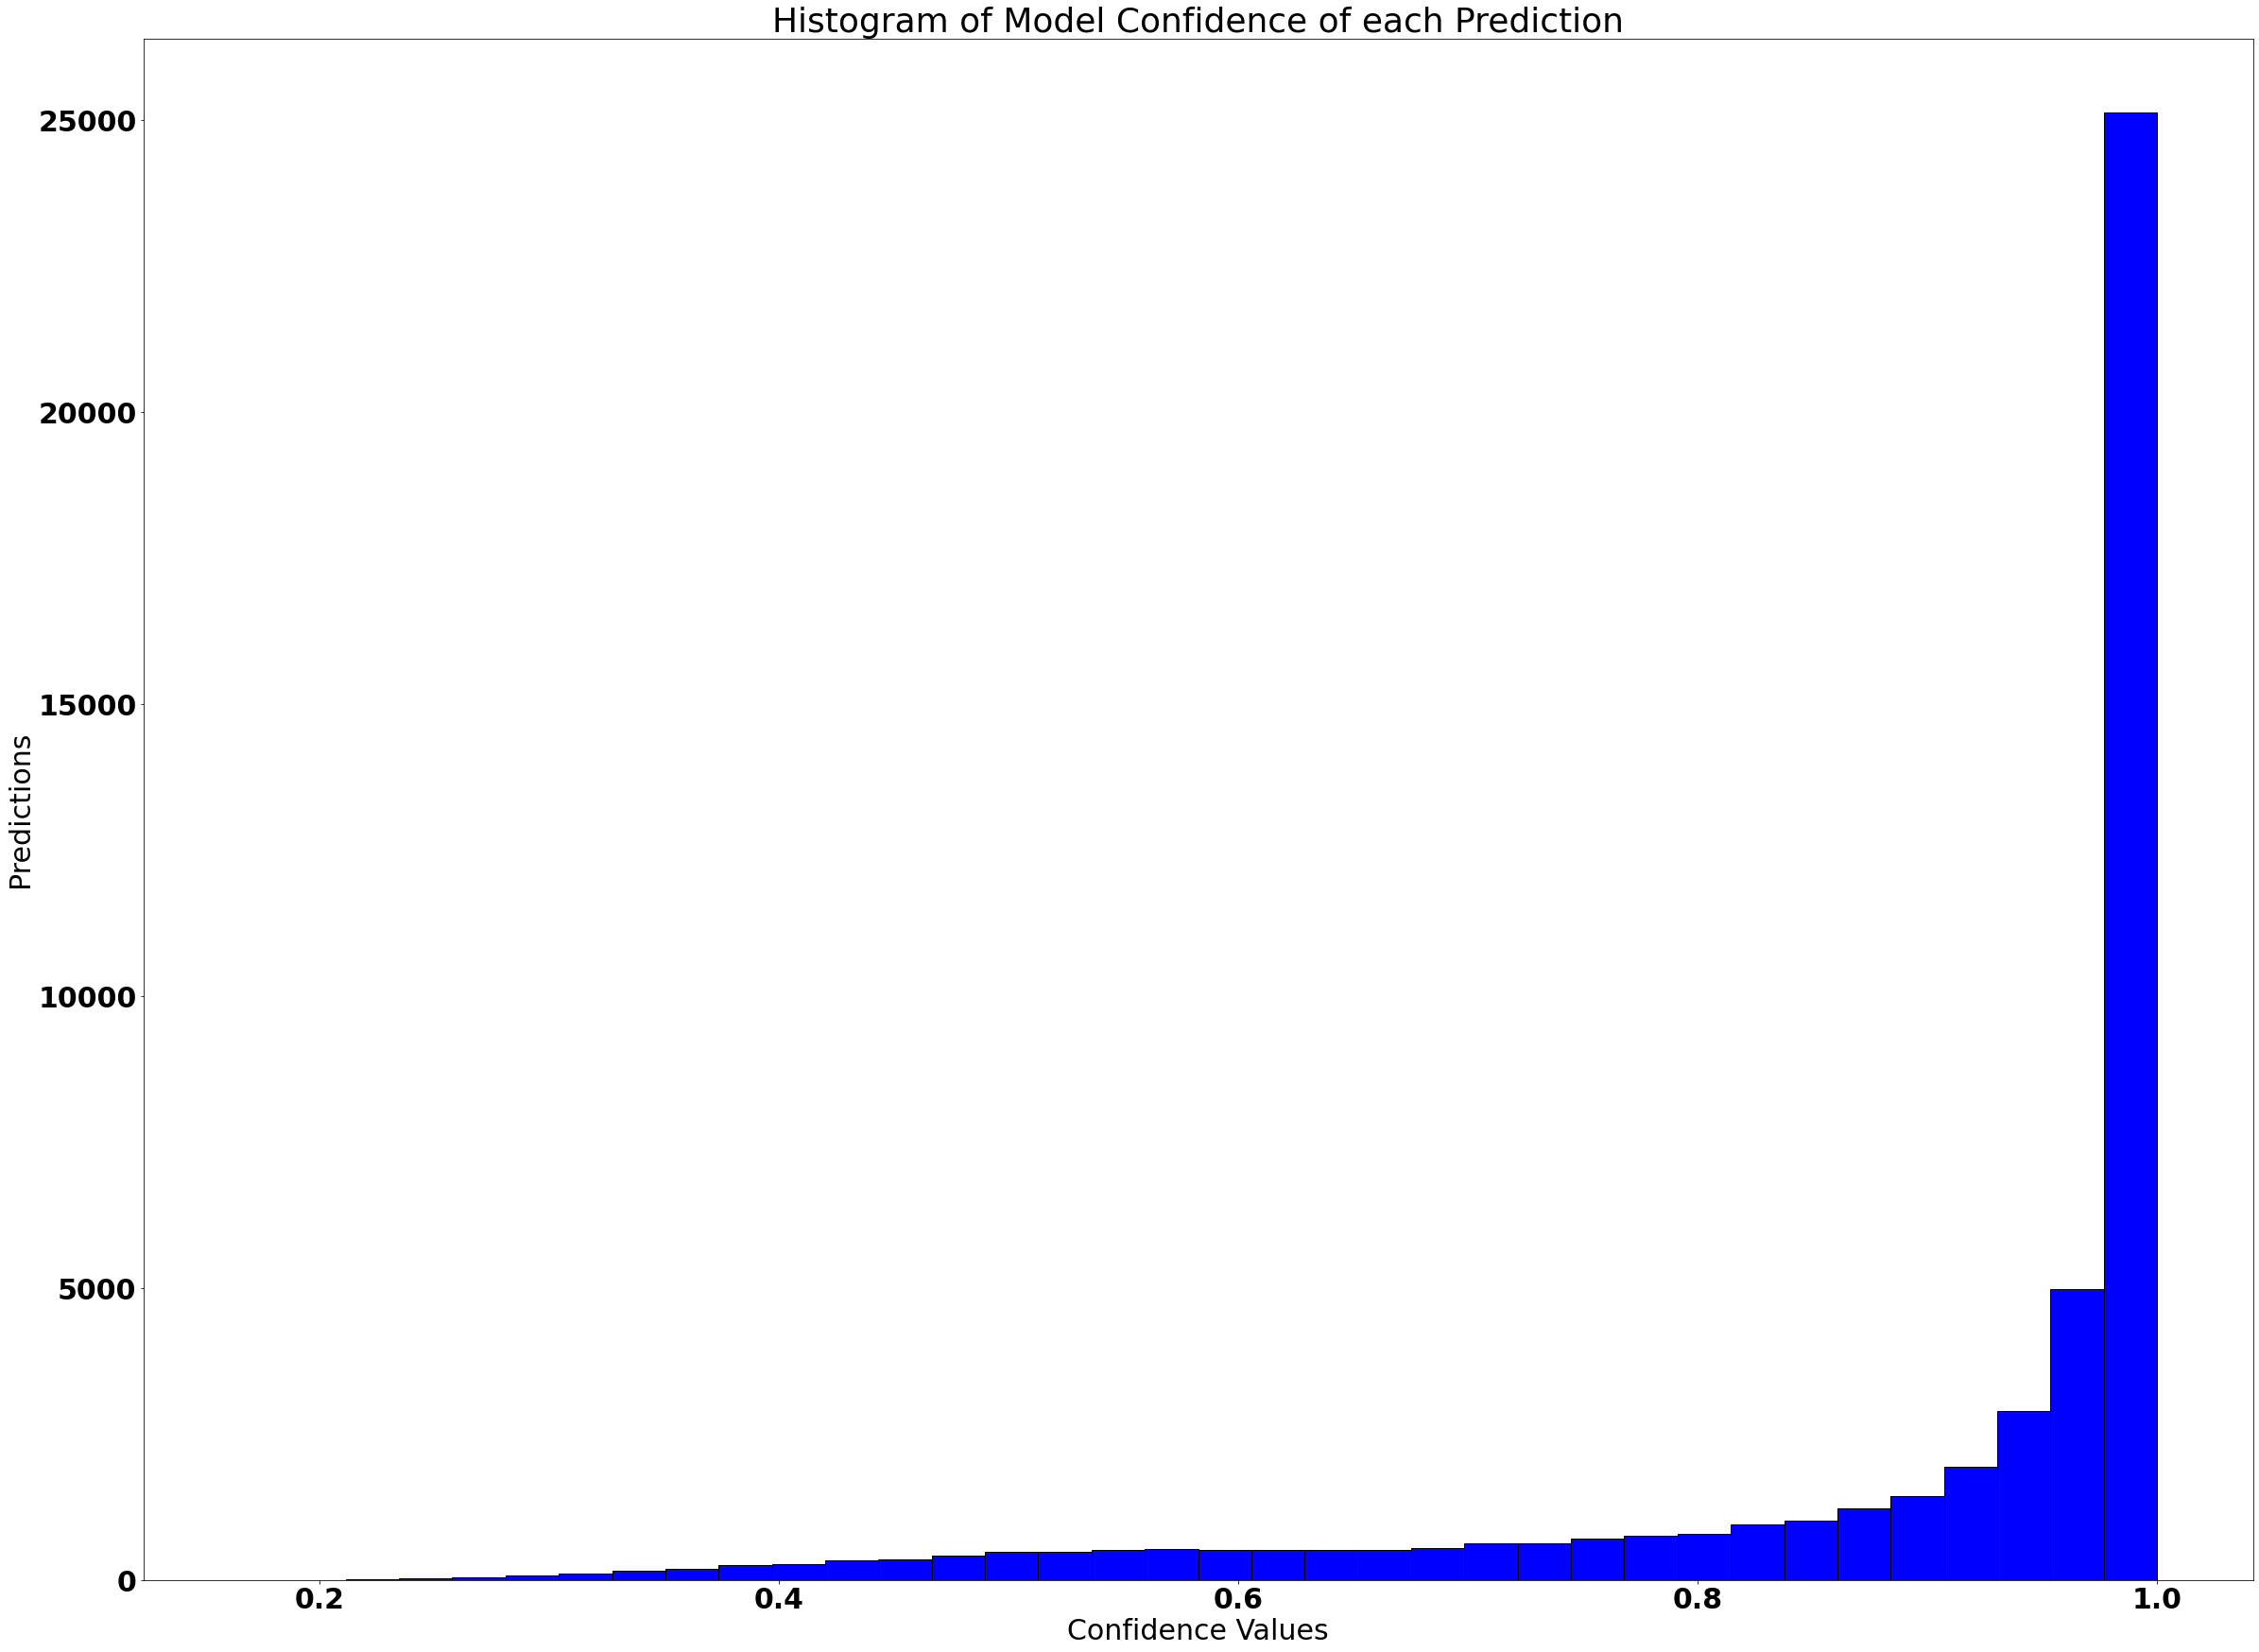

In [64]:
%matplotlib inline
import seaborn as sns
import matplotlib
font = {'family' : 'sans',
        'weight' : 'bold',
        'size'   : 30}
matplotlib.rc('font', **font)
plt.figure( figsize = (40, 30))
plt.hist(np.amax(p, axis = 1), color = 'blue', edgecolor = 'black',
         bins = int(180/5))
# Add labels
plt.title('Histogram of Model Confidence of each Prediction')
plt.xlabel('Confidence Values')
plt.ylabel('Predictions')
plt.show()

This is a histogram of the confidence of the model (a sorta pdf) produced by the prediction confidence on the training set.

In [75]:
p.shape

(50000, 10)

In [90]:
p1 = model1.predict(trainX,  verbose = 1)

50000/50000 [==============================] - 25s 506us/sample


In [92]:
conf = tf.math.confusion_matrix(np.argmax(trainY, axis = 1),np.argmax(p1, axis = 1))

In [103]:
np.array(conf)

array([[4530,    7,  194,    4,   44,    1,   14,   22,  149,   35],
       [   9, 4858,    2,    3,    0,    1,   15,    1,   51,   60],
       [ 102,    1, 4430,   34,  159,   45,  178,   40,    9,    2],
       [  31,    3,  238, 3441,  213,  548,  355,  121,   31,   19],
       [  13,    0,  118,   28, 4628,   21,   88,  100,    4,    0],
       [   3,    0,  194,  238,  199, 4115,   57,  187,    4,    3],
       [   3,    1,  107,   22,   34,    7, 4814,    2,   10,    0],
       [  11,    1,   63,   45,  119,   60,   11, 4682,    4,    4],
       [  34,   16,    5,    1,    4,    1,    6,    1, 4924,    8],
       [  58,  118,    6,    4,    2,    3,   16,    8,   61, 4724]])

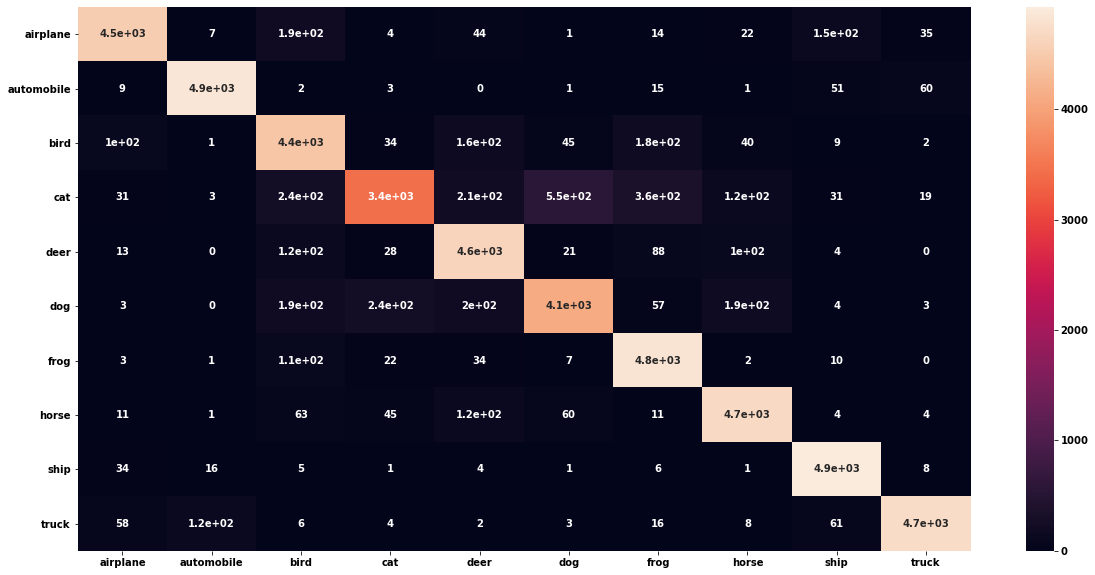

In [127]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
font = {'family' : 'sans',
        'weight' : 'bold',
        'size'   : 10}
matplotlib.rc('font', **font)
labels_names = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship',
                'truck']
df_cm = pd.DataFrame(np.array(conf), index = [i for i in labels_names],
                  columns = [i for i in labels_names])
plt.figure(figsize = (20,10))
sn.heatmap(df_cm, annot=True)